In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles,make_blobs,make_moons
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
from sklearn.metrics import silhouette_score

kmeans 0.3537906347925573
kmeans 0.4892206817177722
kmeans 0.7863738237114819
kmeans 0.3582048124896517
DBSCAN 0.1144744237814493
DBSCAN 0.3346659565571806
DBSCAN 0.8260921886020176
AgglomerativeClustering 0.3366248998144355
AgglomerativeClustering 0.44679712539823946
AgglomerativeClustering 0.7863738237114819
AgglomerativeClustering 0.3243564425759335


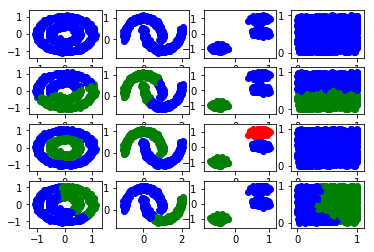

In [7]:
n_samples=1000
circles=make_circles(n_samples=n_samples,factor=0.5,noise=0.05)
moons=make_moons(n_samples=n_samples,noise=0.05)
blobs=make_blobs(n_samples=n_samples,random_state=8,center_box=(-1,1),cluster_std=0.1)
random_data=np.random.rand(n_samples,2),None#这个None目的是让random_data的数据结构和上面的相同
colors='bgrcmyk'
data=[circles,moons,blobs,random_data]
models=[('None',None),('kmeans',KMeans(n_clusters=2)),('DBSCAN',DBSCAN(min_samples=3,eps=0.2)),('AgglomerativeClustering',AgglomerativeClustering(n_clusters=2))]
f=plt.figure()
for inx,clt in enumerate(models):
    clt_name,clt_entity = clt
    for i,dataset in enumerate(data):
        X,Y=dataset
        if not clt_entity:
            clt_res=[0 for item in range(len(X))]
        else:
            clt_entity.fit(X)
            clt_res=clt_entity.labels_.astype(np.int)
        try:
            print(clt_name,silhouette_score(X,clt_res))
        except:
            pass
        f.add_subplot(len(models),len(data),inx*len(data)+i+1)
        [plt.scatter(X[p,0],X[p,1],color=colors[clt_res[p]]) for p in range(len(X))]#挺有意思的写法，有空多看看
plt.show()
            
            
    

In [53]:
from itertools import combinations
def comb(lst):
    ret=[]
    for i in range(1,len(lst)+1):#获取一个事务所有维度的项目集
        ret+=list(combinations(lst,i))
    return ret

class AprLayer(object):
    d=dict() #???这个有啥用
    def __init__(self):#通过字典保存对应的节点对象
        self.d=dict()
        
class AprNode(object):
    def __init__(self,node):
        self.s=set(node)#节点的项目集合
        self.size=len(self.s)#节点的项目个数
        self.lnk_nodes=dict()#用于保存节点对应的用此节点组成的更高维度节点
        self.num=0#这个节点出现的个数，通过以下hash封装再在eq里比较，相同的话加1
    def __hash__(self):#封装节点以便于比较节点是否相同
        return hash('__'.join(sorted([str(itm) for itm in list(self.s)])))#估计是通过排序加下划线来保证节点的唯一性便于比较
    def __eq__(self,other):#比较节点是否相同
        if '__'.join(sorted([str(itm) for itm in list(self.s)])) == '__'.join(sorted([str(itm) for itm in list(other.s)])):
            return True
        return False
    def isSubnode(self,node):#判断节点是否括号里节点的子节点
        return self.s.issubset(node.s)
    def incNum(self,num=1):#增加num的值，方便记录节点出现的次数
        self.num+=num
    def addLink(self,node):#用于把节点对应的用此节点组成的更高维度节点进行关联
        self.lnk_nodes[node]=node.s
        
class AprBlk(object):#整体框架的类
    def __init__(self,data):
        self.cnt=0#保存进行到第几个事务的计数
        self.apr_layers=dict()#层变量，用于保存不同项目个数的层对象
        self.data_num=len(data)#保存事务个数
        for datum in data:
            self.cnt+=1
            datum=comb(datum)#把事务的所有项目集变成列表
            nodes=[AprNode(da) for da in datum]#把所有的项目集节点化
            for node in nodes:
                if not node.size in self.apr_layers:#判断对应项目个数的层对象是否存在，不存在则创建
                    self.apr_layers[node.size]=AprLayer()
                if not node in self.apr_layers[node.size].d:#判断节点是否在对应的层对象里存在，若没有则添加到对应层对象的字典里
                    self.apr_layers[node.size].d[node]=node#这里没问题吗
                self.apr_layers[node.size].d[node].incNum()#每循环一次想赢节点的num数加一，方便之后统计频率以及置信
            for node in nodes:#循环所有的节点，先判断他是否有更低维度的关联节点，若无，则跳过，若有，则找出所有关联的低一维节点进行关联
                if node.size==1:
                    continue
                for sn in node.s:
                    sub_n=AprNode(node.s-set([sn]))#-set([sn])如果变成-set((sn))会报错
                    self.apr_layers[node.size-1].d[sub_n].addLink(node)
                    
    def getFreqItems(self,thd=1,hd=1):
        freq_items=[]#循环判断每个节点出现的次数有无超过阈值，没有则跳过，有则以节点值\
        #和出现个数的元组形式添加到列表里，最后排序，以参数规定的个数返回
        for layer in self.apr_layers:
            for node in self.apr_layers[layer].d:
                if self.apr_layers[layer].d[node].num < thd:
                    continue
                freq_items.append((self.apr_layers[layer].d[node].s,self.apr_layers[layer].d[node].num))
        freq_items.sort(key=lambda x:x[1],reverse=True)
        return freq_items[:hd]
    
    def getConf(self,low=True,h_thd=10,l_thd=1,hd=1):
        confidence=[]#找到节点以及相应的高一维节点，判断是否超过阈值，若都超过则算置信度，\
        #并加入到结果列表里，排序，根据参数输出高置信组合或者低置信组合。
        for layer in self.apr_layers:
            for node in self.apr_layers[layer].d:
                if self.apr_layers[layer].d[node].num<h_thd:
                    continue
                for lnk_node in node.lnk_nodes:
                    if lnk_node.num<l_thd:
                        continue 
                    conf=float(lnk_node.num)/float(node.num)
                    confidence.append([node.s,node.num,lnk_node.s,lnk_node.num,conf])
        confidence.sort(key=lambda x:x[4])
        if low:
            return confidence[:hd]
        else:
            return confidence[-hd::-1]
    
    def getimprove(self,thd=10,hd=1):
        improve=[]
        for layer in self.apr_layers:
            for node in self.apr_layers[layer].d:
                if self.apr_layers[layer].d[node].num<thd:
                    continue
                for lnk_node in node.lnk_nodes:
                    if lnk_node.num<thd:
                        continue 
                    conf=float(lnk_node.num)/float(node.num)
                    other=AprNode(lnk_node.s-node.s)
                    other=self.apr_layers[other.size].d[other]
                    imp=conf/(float(other.num)/float(self.cnt))
                    improve.append([other.s,other.num,lnk_node.s,lnk_node.num,conf,imp])
        improve.sort(key=lambda x:x[5],reverse=True)
        return improve[:hd]
    
class AssctAnaClass():#主类
    def fit(self,data):#把数据apriori化
        self.apr_blk=AprBlk(data)
        return self
    def get_freq(self,thd=1,hd=1):#或许高频项目集
        return self.apr_blk.getFreqItems(thd=thd,hd=hd)
    def get_conf_high(self,thd,h_thd=10):#获取高置信组合
        return self.apr_blk.getConf(low=False,h_thd=thd,l_thd=thd)
    def get_conf_low(self,thd,hd,l_thd=1):#获取低置信组合
        return self.apr_blk.getConf(h_thd=thd,l_thd=l_thd,hd=hd)
    def get_imp(self,thd,hd):
        return self.apr_blk.getimprove(thd=thd,hd=hd)
    

    
def main():
    data=[
        ["牛奶","啤酒","尿布"],
        ["牛奶","啤酒","咖啡","尿布"],
        ["香肠","牛奶","饼干"],
        ["尿布","果汁","啤酒"],
        ["钉子","啤酒"],
        ["尿布","毛巾","香肠"],
        ["啤酒","毛巾","尿布","饼干"]
    ]
    print("Freq",AssctAnaClass().fit(data).get_freq(thd=3,hd=10))
    print("Conf",AssctAnaClass().fit(data).get_conf_high(thd=3,h_thd=3))
    print('提升度',AssctAnaClass().fit(data).get_imp(thd=3,hd=10))
    
if __name__=="__main__":
    main()
                
    
        
    

Freq [({'啤酒'}, 5), ({'尿布'}, 5), ({'尿布', '啤酒'}, 4), ({'牛奶'}, 3)]
Conf [[{'尿布'}, 5, {'尿布', '啤酒'}, 4, 0.8], [{'啤酒'}, 5, {'尿布', '啤酒'}, 4, 0.8]]
提升度 [[{'尿布'}, 5, {'尿布', '啤酒'}, 4, 0.8, 1.12], [{'啤酒'}, 5, {'尿布', '啤酒'}, 4, 0.8, 1.12]]


In [34]:
tem=dict()
x=2
tem[x]=x
print(tem)

{2: 2}
